In [1]:
import os
import sys
import json
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from tqdm.asyncio import tqdm_asyncio

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import Config
from services.openai_service import OpenAIService
from services.tavily_service import TavilyService
from services.feature_extractor_agent_v2 import FeatureExtractor

# Load configuration
config = Config()
openai_service = OpenAIService(config.OPENAI_API_KEY, config)
tavily_service = TavilyService(config.TAVILY_API_KEY)
feature_extraction = FeatureExtractor(openai_service, tavily_service, max_attempts=5)

# Set up Pandas and Seaborn
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Load the data
old_products = pd.read_csv("../data/filtered_products.csv")
old_products.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1133 non-null   object
 1   raw_data               1133 non-null   object
 2   raw_length             1133 non-null   int64 
 3   name                   1133 non-null   object
 4   size                   819 non-null    object
 5   form                   834 non-null    object
 6   processor              1028 non-null   object
 7   core                   536 non-null    object
 8   frequency              759 non-null    object
 9   memory                 999 non-null    object
 10  voltage                988 non-null    object
 11  io                     1091 non-null   object
 12  thermal                871 non-null    object
 13  feature                1120 non-null   object
 14  type                   1127 non-null   object
 15  specification        

In [3]:
raw_data = old_products[["id", "raw_data"]].copy()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1133 non-null   object
 1   raw_data  1133 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB


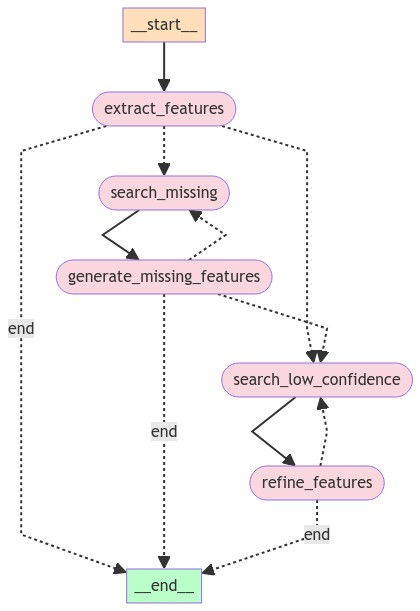

In [4]:
# Display the workflow graph
display(Image(feature_extraction.workflow.get_graph().draw_mermaid_png()))

In [5]:
# Test the feature extraction on a single product
text = raw_data.tail(1)["raw_data"].values[0]
print(text)

A Mini PC User Gride afn A Mini PC A Mini PC User Guide Notice Packing List Product Introduction Brief Specifications Install Dimension Interfaces Jetpack KEY FEATURES IN JETPACK Sample Applications Develop Tool Notice Please read manual carefully install operate transport device Ensure correct power range used powering device Avoid hot plugging To properly turn power please shut Ubuntu system first cut power Due particularity Ubuntu system Nvidia developer kit power turned startup completed probability abnormality cause device fail start Due use Ubuntu system problem also exists device Do use cables connectors described manual Do use device near strong magnetic fields Backup data transportation device idle Recommend transport device original packaging Packing List A mini PCx Antenna x Power adapterWithout Power cord x afn Processor NVIDIA Jetson Xavier NX AI Performance TOPS INT GPU core NVIDIA Volta GPU Tensor Cores GPU Max Freq MHz A Mini PC Product Introduction Brief A Mini PC powe

In [6]:
await feature_extraction.extract_data(text)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::


{'name': 'Mini PC',
 'manufacturer': 'NVIDIA',
 'form_factor': 'Small form factor',
 'processor': 'NVIDIA Jetson Xavier NX',
 'core_count': '6',
 'processor_tdp': '15W',
 'memory': '8 GB LPDDR4x',
 'io': 'HDMI, USB Type-A, microUSB, RJ45 Ethernet, SIM Card Slot',
 'operating_system': 'Ubuntu',
 'environmentals': 'Operating Temperature: -25°C to 80°C, Storage Temperature: -40°C to 85°C, Storage Humidity: 5% to 95% non-condensing',
 'certifications': 'FCC, CE, RoHS',
 'short_summary': 'A powerful and extremely small intelligent edge computer with NVIDIA Jetson Xavier NX processor, suitable for AI applications.',
 'full_summary': 'The Mini PC is a powerful and extremely small intelligent edge computer that brings modern AI to the edge in a smaller form factor. It features the NVIDIA Jetson Xavier NX processor, delivering AI power of up to 21 TOPS. It is ideal for smart cities, security, industrial automation, smart factories, and edge AI solution providers.',
 'full_product_description': 

## Processed data

In [4]:
processed_a = pd.read_csv("../data/extracted_data_combined.csv")
processed_a = processed_a.dropna(subset=["data"])
processed_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1095 non-null   object
 1   data    1095 non-null   object
dtypes: object(2)
memory usage: 17.2+ KB


In [5]:
processed_b = pd.read_csv("../data/extracted_data_final.csv")
processed_b = processed_b.dropna(subset=["data"])
processed_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 0 to 37
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10 non-null     object
 1   data    10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [6]:
# Combine the two datasets by id
processed = pd.concat([processed_a, processed_b])
processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, 0 to 37
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1105 non-null   object
 1   data    1105 non-null   object
dtypes: object(2)
memory usage: 25.9+ KB


In [7]:
# Save the data
processed.to_csv("../data/extracted_data_combined.csv", index=False)

In [8]:
# select from raw_data products that are not in processed
raw_data = raw_data[~raw_data["id"].isin(processed["id"])]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 37 to 1118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        40 non-null     object
 1   raw_data  40 non-null     object
dtypes: object(2)
memory usage: 960.0+ bytes


In [9]:
raw_data["raw_data_len"] = raw_data["raw_data"].apply(len)
raw_data = raw_data.sort_values("raw_data_len", ascending=True)
raw_data.head()

,id,raw_data,raw_data_len
354,PBQ-3000-RED R1.2,PBQ Qseven Carrier Board EPIC Form Factor C Features Qseven Carrier Board Dual Gigabit Ethernet Ports Integrated Gigabit Ethernet Single Channel bit LVDS Dual Channels bit LVDS Analog RGB DVI Wide Range DC Power Input V V IO Super IO Chipset Fintek FED Serial Port x RS x RS selectable Digital IO bit Programmable Mechanical Environmental Power Requirement V V Power Consumption AV EmQiE Typical Operating Temp C F Keyboard Mouse USB interface Keyboard Mouse Operating Humidity C noncondensing USB Expansion Storage Ethernet Chipset Digital IO Audio Display x USB ports x MiniCard Socket LPC x SATA connector x CPU module x Intel V PCIe GbE controller bit Programmable Realtek ALC Channel HD Audio CODEC Micin Linein Lineout Analog RGB DVI x VGA connector Graphic Interface LCD x LVDS connector DDI port x DisplayPort connector OS Support Depends CPU Module Dimensions L x W Dimensions mm x mm x Unit mm All specifications subject change without noticewwwarborcomtwComputer Module Block Diagram DCIN Wide Range DC Input V Power buttom LEDs DCjack bit Dual Single Channels LVDS DP Chrontel CH DVI Analog RGB Q reserved pin EmQi LPC IF LPC IF r c e n n C n e v e Q Fintek FDI Super IO bit DIO COM COM COM COM USB PCIex LVDS DVID Connector VGA Connector LPC connector bit Digital IO Connector x RS x RS x RS x MiniCard socket HD Audio Link Realtek ALC CODEC Mic Linout AUDIO PCIex Intel V GbE Controller GbE LAN x USB Ports GbE LAN x USB Ports x USB Ports SATA RJ Double Stacked USB Type A RJ Double Stacked USB Type A x USB x SATA Conn Ordering Information PBQ Qseven R carrier board EPIC form factor Optional Accessories CBK Cable kit x USB cable x USB cable x Serial port cables x SATA cable x SATA power cable Last update Mouser Electronics Authorized Distributor Click View Pricing Inventory Delivery Lifecycle Information ARBOR Technology PBQRED R,1850
513,MANO526-Q370 A20 Single Packing,Axiomtek Co Ltd All rights reservedwwwaxiomtekcom MANO MiniITX SBC LGA Socket thth Gen Intel Core Processor Intel Q HDMI DisplayPort eDP GbE LAN HD Audio Features Specifications Core System CPU LGA socket thth gen Intel Core iii Intel Pentium processors GoldCeleron processors W System Memory x pin DDR SODIMM GB Chipset Intel Q BIOS AMI SSD x M Key M supports NVMe Watchdog Timer levels sec Expansion Interface x PCIe x x M Key E Battery Lithium Lithium VmAH Power Input STD V ATX power pin ATX connector AT Mode Auto Power function supported Display Chipset Intel integrated Gfx graphic engine Memory Size Share system memory Display Interface x DisplayPort x eDP x HDMI Side view x GbE x USB x DisplayPort x HDMI x COM x USB Audio LGA socket thth gen Intel Core iii processor Intel Q chipset DDR SODIMM GB memory USB USB COM ports SATA M Key M PCIe x M Key E Rear view TripleView Updated Oct All specifications photos subject change without notice MiniITX Motherboards IO SATA x SATA Hardware Monitoring Detect CPUsystem temperature voltage fan speed Ethernet x Mbps Ethernet Intel IAT supports WakeonLAN PXE Boot ROM x Mbps Ethernet Intel ILM supports WakeonLAN PXE Boot ROM Audio HD Codec audio MICinLineinLineout Realtek ALCS USB x USB x USB Serial x RS VV power x RS TPM Onboard TPM SMBus NA Digital IO channel inout programmed Mechanical Environmental Dimensions x mm Board Thickness mm Operating Temperature C C F F Humidity relative humidity noncondensing Packing List IO bracket Ordering Information Standard MANO MiniITX SBC LGA socket thth gen Intel Core processor Intel Q HDMI DisplayPort eDP GbE LAN HD Audio Optional ME x COM port P mm L mm EE x USB wafer cable bracket P L mm PLAE LGA U H Mouser Electronics Authorized Distributor Click View Pricing Inventory Delivery Lifecycle Information Axiomtek MANOQ A Single Packing httpswwwmousercomaxiomtek httpswwwmousercomaccesspnMANOQ A Single Packing,1913
681,HPC-7400MB-70A1E,Server Chassis Features HPC U Compact Rackmount Tower Chassis EATXATXMicroATX Motherboard U compact industrial server ch

In [10]:
# Function to process a single product
async def process_product(product):
    try:
        data = await feature_extraction.extract_data(product['raw_data'])
        return {"id": product['id'], "data": data}
    except Exception as e:
        print(f"Error processing product {product['id']}: {e}")
        return {"id": product['id'], "data": None}

In [11]:
# Function to save progress
def save_progress(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Progress saved to {filename}")

In [12]:
# Main function to process all products
async def process_all_products(raw_data, batch_size=10, save_interval=10):
    all_products = raw_data.to_dict('records')
    extracted_data = []

    for i in range(0, len(all_products), batch_size):
        batch = all_products[i:i+batch_size]
        tasks = [process_product(product) for product in batch]
        results = await tqdm_asyncio.gather(*tasks, desc=f"Processing batch {i//batch_size + 1}")
        extracted_data.extend(results)

        if len(extracted_data) % save_interval == 0:
            save_progress(extracted_data, "../data/extracted_data_partial.csv")

    return extracted_data

In [13]:
# Run the feature extraction
extracted_data = await process_all_products(raw_data)

Processing batch 1:   0%|          | 0/10 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 1:  10%|█         | 1/10 [00:27<04:03, 27.10s/it]

Error processing product EmETXe-i65M2-827E: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product DEVKIT-ZVL128: string indices must be integers
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 1:  30%|███       | 3/10 [00:42<01:28, 12.58s/it]

Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product MM2-IP-DEVKIT: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product MANO526-Q370 A20 Single Packing: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product MANO520PHGGA-H310 Gift Box: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product UPN-ADLNI3-A10-1664: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 1:  70%|███████   | 7/10 [01:01<00:22,  7.34s/it]

Error processing product MANO560-H-S S: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 1:  80%|████████  | 8/10 [01:08<00:14,  7.19s/it]

Error processing product HPC-7400MB-70A1E: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 1:  90%|█████████ | 9/10 [01:22<00:08,  8.78s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 1: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


Progress saved to ../data/extracted_data_partial.csv


Processing batch 2:   0%|          | 0/10 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 2:  10%|█         | 1/10 [00:39<05:59, 39.91s/it]

Error processing product SNMP-1000-E1B1E: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product MDL-IDM-L35: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product VL-EBXE-41SMK: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


Processing batch 2:  40%|████      | 4/10 [00:56<01:12, 12.06s/it]

Error processing product ACK-A004E-01A1E: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 2:  50%|█████     | 5/10 [01:22<01:20, 16.01s/it]

Error processing product SK513-T604Q03: 'confidence'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 4 attempts ::
Processing batch 2:  60%|██████    | 6/10 [01:46<01:12, 18.21s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 2:  70%|███████   | 7/10 [01:50<00:42, 14.04s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/comple

Progress saved to ../data/extracted_data_partial.csv


Processing batch 3:   0%|          | 0/10 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 3:  10%|█         | 1/10 [00:33<05:05, 33.94s/it]

Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product 114110107: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product UP2-DEVKITslashUNIV: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 3:  30%|███       | 3/10 [00:47<01:37, 13.87s/it]

Error processing product D:\mouser\mouser_devkit\AR1100BRD: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 3:  40%|████      | 4/10 [01:06<01:33, 15.61s/it]

Error processing product FLDSC-ASY-02-XNX: string indices must be integers
Error processing product ISL99227FRZ-T7A: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 3:  60%|██████    | 6/10 [01:11<00:36,  9.07s/it]

Error processing product TPM9673FW2613RPIEBTOBO1: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:openai._base_client:Retrying request to /chat/completions in 0.809074 seconds
Processing batch 3:  70%|███████   | 7/10 [01:17<00:24,  8.24s/it]

Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product VL-EPME-42SAP-00: 400 Client Error: Bad Request for url: https://api.tavily.com/search


Processing batch 3:  80%|████████  | 8/10 [01:18<00:12,  6.26s/it]

Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product ARK-5420-U7A1E: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 3:  90%|█████████ | 9/10 [01:27<00:07,  7.07s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 3: 100%|██████████| 10/10 [01:35<00:00,  9.56s/it]


Error processing product PLS83-X DEVKIT: string indices must be integers
Progress saved to ../data/extracted_data_partial.csv


Processing batch 4:  10%|█         | 1/10 [00:10<01:34, 10.46s/it]

Error processing product 101-0303: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 4:  20%|██        | 2/10 [00:12<00:43,  5.45s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing product 68004-0000-99-1: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 4:  30%|███       | 3/10 [00:17<00:36,  5.17s/it]

Error processing product 101-0539: string indices must be integers
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 4:  40%|████      | 4/10 [00:30<00:50,  8.41s/it]

Error processing product IW-G34D-SM04-4L001G-E008G-LCD: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product IW-G27D-SCQM-4L004G-E016G-ACJ: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search


Processing batch 4:  60%|██████    | 6/10 [00:40<00:26,  6.56s/it]

Error processing product iW-G36S-5EV1-4E002G-E008G-BEE: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 4:  70%|███████   | 7/10 [00:49<00:21,  7.21s/it]

Error processing product 110110110: string indices must be integers


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Processing batch 4:  80%|████████  | 8/10 [00:59<00:16,  8.05s/it]

Error in Tavily search: 400 Client Error: Bad Request for url: https://api.tavily.com/search
Error processing product RTPF-DEV-KIT-CG: 400 Client Error: Bad Request for url: https://api.tavily.com/search


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 4:  90%|█████████ | 9/10 [01:08<00:08,  8.17s/it]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.feature_extractor_agent_v2::: Ending extraction after 5 attempts ::
Processing batch 4: 100%|██████████| 10/10 [01:09<00:00,  6.97s/it]

Progress saved to ../data/extracted_data_partial.csv


In [14]:

# Save final results
extracted_df = pd.DataFrame(extracted_data)
extracted_df.info()
extracted_df.to_csv("../data/extracted_data_final.csv", index=False)

print("Feature extraction complete!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40 non-null     object
 1   data    10 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes
Feature extraction complete!


In [13]:
extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1133 non-null   object
 1   data    237 non-null    object
dtypes: object(2)
memory usage: 17.8+ KB
